## Для задачи сегментации был выбран 2-ой сценарий и задача семантической сегментации ядер в биологических клетках

### Загрузка библиотек

In [2]:
import albumentations as albu
from albumentations.pytorch import ToTensor
import torch
from tqdm.notebook import tqdm
import sys
import os
import cv2
import torchvision
import pathlib
import imageio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from scipy import ndimage
import pandas as pd
import random
from skimage.io import imread as gif_imread
from typing import List
from torch.utils.data import Dataset


# Задание - 1 
## Загрузка модели

In [3]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True, progress=True, num_classes=91, \
                                                           pretrained_backbone=True).eval().cuda()


# Задание 2
## Использование модели на пользовательском изображении

In [4]:
test_img=cv2.imread('test.jpg')
test_img=test_img[:,:,::-1]
img=test_img/255
torch_test_img=torch.from_numpy(img.astype('float32')).permute(2,0,1).cuda()
torch_test_img=torch_test_img[None,:]
predictions=model(torch_test_img)

In [5]:
def plot_preds(numpy_img,predictions):
    boxes=predictions['boxes']
    boxes=boxes.cpu().detach().numpy()
    for box in boxes:
        numpy_img=cv2.rectangle(numpy_img,(box[0],box[1],box[2],box[3]),255,3)
    return numpy_img.get()

In [6]:
CONF_THRESH=0.5
predictions=predictions[0]
boxes=predictions['boxes'][predictions['scores']>CONF_THRESH]
boxes_dict={}
boxes_dict['boxes']=boxes

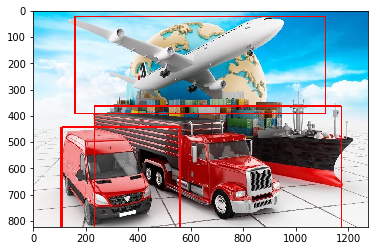

In [7]:
boxes_img=plot_preds(test_img,boxes_dict)

plt.imshow(boxes_img.astype('uint'))

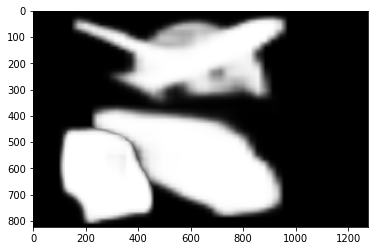

In [8]:
CONF_THRESH=0.5

boxes=predictions['masks'][predictions['scores']>CONF_THRESH]
masks_dict={}
masks_dict['masks']=boxes
masks_dict['masks']=masks_dict['masks'].permute(0,2,3,1).detach().cpu().numpy().reshape(4,823,1276)
end_mask = np.ndarray(shape=(823,1276))
for item in masks_dict['masks']:
    end_mask=np.where(item>end_mask, item,end_mask) 
plt.imshow(end_mask,cmap='gray')

### Пользовательская проверка использования видеопамяти

In [2]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cuda

GeForce GTX 1050 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


# Задание - 3
## Был выбран датасет с семантической сегментацией ядер в биологических клетках:
## Ссылка на kaggle - https://www.kaggle.com/c/data-science-bowl-2018/overview

# Задание - 4 
## Предобработка

Перенос данных в "image" и "masks" папки. Все подмаски объеденяются в единое изображение маски.

In [ ]:
def train_img_preprocess():
    os.chdir('input/stage1_train')
    im_path_list=os.listdir()
    sys.stdout.flush()
    pbar = tqdm(total=len(im_path_list),position=0)
    for n, im_path in (enumerate(im_path_list)):
        os.chdir(im_path)
        
        image_name=pathlib.Path().glob('images/*.png')
        image_name=str(next(image_name).parts[-1])
        im = imageio.imread('images/'+image_name)
        imageio.imwrite('../../train/images/'+image_name,im)

        list_masks=pathlib.Path().glob('masks/*.png')
        full_mask=next(list_masks)
        full_mask = cv2.imread(str(full_mask), cv2.IMREAD_GRAYSCALE)
        for i in list_masks:
            item= cv2.imread(str(i), cv2.IMREAD_GRAYSCALE)
            full_mask=np.where(item>full_mask, item,full_mask)  
        imageio.imwrite('../../train/masks/'+image_name,full_mask)
        os.chdir('../')
        
        pbar.update(1)
    os.chdir('../../')
    pbar.close()

In [ ]:
def test_img_preprocess():
    sys.stdout.flush()
    os.chdir('input/stage1_test')
    testing=os.listdir()
    pbar= tqdm(total=len(testing),position=1)
    os.chdir('../../')
    
    
    testing = pathlib.Path('input/stage1_test').glob('*/images/*.png')
    for  i in testing:
        im_id = i.parts[-3]
        img = imageio.imread(str(i))
        imageio.imwrite('input/test/images/'+im_id+'.png',img)
        pbar.update(1)
    pbar.close()

In [ ]:
#%%capture
train_img_preprocess()
test_img_preprocess()

In [5]:
# this variable will be used in `runner.train` and by default we disable FP16 mode
is_fp16_used = False
is_alchemy_used = False

In [6]:
import IPython
def configure_plotly_browser_state():
    display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))


IPython.get_ipython().events.register('pre_run_cell', configure_plotly_browser_state)

In [7]:
from typing import Callable, List, Tuple
import catalyst
from catalyst.dl import utils

print(f"torch: {torch.__version__}, catalyst: {catalyst.__version__}")

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # "" - CPU, "0" - 1 GPU, "0,1" - MultiGPU

SEED = 42
utils.set_global_seed(SEED)
utils.prepare_cudnn(deterministic=True)

torch: 1.4.0, catalyst: 20.01.1


In [8]:

if is_alchemy_used:
    monitoring_params = {
        "token": "...", # insert your personal token here
        "experiment": "segmentation_example"
    }
else:
    monitoring_params = None

In [9]:
is_alchemy_used

False

In [10]:
ROOT = pathlib.Path("input/")

train_image_path = ROOT / "train/images"
train_mask_path = ROOT / "train/masks"
test_image_path = ROOT / "test/images"

In [11]:
ALL_IMAGES = sorted(train_image_path.glob("*.png"))
len(ALL_IMAGES)

670

In [12]:
ALL_MASKS = sorted(train_mask_path.glob("*.png"))
len(ALL_MASKS)

670

In [13]:
from skimage.io import imread as gif_imread
from catalyst import utils

def show_examples(name: str, image: np.ndarray, mask: np.ndarray):
    plt.figure(figsize=(10, 14))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Image: {name}")

    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.title(f"Mask: {name}")


def show(index: int, images: List[pathlib.Path], masks: List[pathlib.Path], transforms=None) -> None:
    image_path = images[index]
    name = image_path.name

    image = utils.imread(image_path)
    mask = gif_imread(masks[index])

    if transforms is not None:
        temp = transforms(image=image, mask=mask)
        image = temp["image"]
        mask = temp["mask"]

    show_examples(name, image, mask)

def show_random(images: List[pathlib.Path], masks: List[pathlib.Path], transforms=None) -> None:
    length = len(images)
    index = random.randint(0, length - 1)
    show(index, images, masks, transforms)

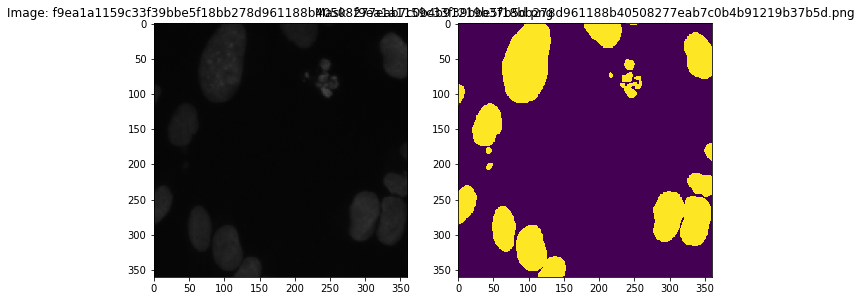

In [14]:
show_random(ALL_IMAGES, ALL_MASKS)

In [15]:

from typing import List

from torch.utils.data import Dataset

class SegmentationDataset(Dataset):
    def __init__(
        self,
        images: List[pathlib.Path],
        masks: List[pathlib.Path] = None,
        transforms=None
    ) -> None:
        self.images = images
        self.masks = masks
        self.transforms = transforms

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int) -> dict:
        image_path = self.images[idx]
        image = utils.imread(image_path)
        
        result = {"image": image}
        
        if self.masks is not None:
            mask = gif_imread(self.masks[idx])
            result["mask"] = mask
        
        if self.transforms is not None:
            result = self.transforms(**result)
        
        result["filename"] = image_path.name

        return result

## Augmentations

In [32]:
BORDER_CONSTANT = 0
BORDER_REFLECT = 2
def pre_transforms(image_size=224):
    # Конвертация размеров изображения
    return [albu.LongestMaxSize(max_size = image_size, p=1),
            albu.PadIfNeeded(image_size, image_size, border_mode=BORDER_CONSTANT)]


def hard_transforms(image_size=224):
    return [albu.RandomRotate90(),
            albu.Flip(),
            albu.Transpose(),
            albu.GaussNoise(),
            albu.OneOf([albu.MotionBlur(p=0.2),
                        albu.MedianBlur(blur_limit=3, p=0.1),
                        albu.Blur(blur_limit=3, p=0.1)], p=0.2),
            albu.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=45, border_mode=BORDER_REFLECT, p=0.2),
            albu.OneOf([albu.OpticalDistortion(p=0.3),
                        albu.GridDistortion(p=0.1)], p=0.2),
            albu.OneOf([albu.CLAHE(clip_limit=2),
                        albu.RandomBrightnessContrast()], p=0.3),
            albu.HueSaturationValue(p=0.3),
            albu.RandomCrop(image_size, image_size, p=0.2)]
  
def post_transforms():
    # we use ImageNet image normalization
    # and convert it to torch.Tensor
    return [albu.Normalize(), ToTensor()]
  
def compose(transforms_to_compose):
    # Комбинация в один список всех items в lists
    result = albu.Compose([
      item for sublist in transforms_to_compose for item in sublist
    ])
    return result

In [17]:
train_transforms = compose([
    pre_transforms(),
    hard_transforms(), 
    post_transforms()
])
valid_transforms = compose([pre_transforms(), post_transforms()])
test_transforms=compose([pre_transforms(),post_transforms()])
show_transforms = compose([pre_transforms(), hard_transforms()])

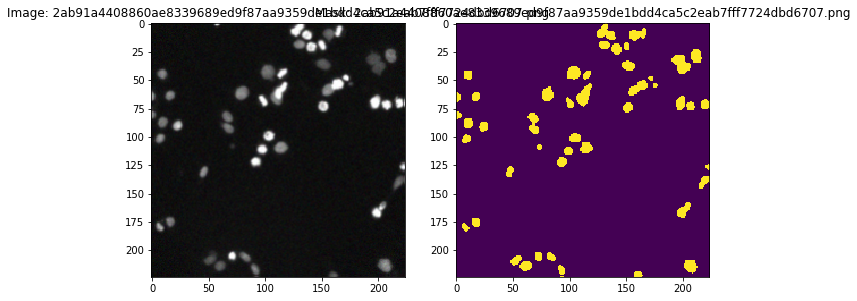

In [18]:
show_random(ALL_IMAGES, ALL_MASKS, transforms=show_transforms)

In [31]:
import collections
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader

def get_loaders(
    images: List[pathlib.Path],
    masks: List[pathlib.Path],
    random_state: int,
    valid_size: float = 0.2,
    batch_size: int = 16,
    num_workers: int = 0,
    train_transforms_fn = None,
    valid_transforms_fn = None,
) -> dict:

    indices = np.arange(len(images))

    # Разделение на train и validation части
    train_indices, valid_indices = train_test_split(
      indices, test_size=valid_size, random_state=random_state, shuffle=True
    )

    np_images = np.array(images)
    np_masks = np.array(masks)

    # Создание train выборки
    train_dataset = SegmentationDataset(
      images = np_images[train_indices].tolist(),
      masks = np_masks[train_indices].tolist(),
      transforms = train_transforms_fn
    )

    # Создание validation выборки
    valid_dataset = SegmentationDataset(
      images = np_images[valid_indices].tolist(),
      masks = np_masks[valid_indices].tolist(),
      transforms = valid_transforms_fn
    )

    # Создание загрузчика данных для выборок
    train_loader = DataLoader(
      train_dataset,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      drop_last=True,
    )

    valid_loader = DataLoader(
      valid_dataset,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      drop_last=True,
    )

    # And excpect to get an OrderedDict of loaders
    loaders = collections.OrderedDict()
    loaders["train"] = train_loader
    loaders["valid"] = valid_loader

    return loaders

In [21]:

if is_fp16_used:
    batch_size = 64
else:
    batch_size = 16
batch_size = 16
print(f"batch_size: {batch_size}")

loaders = get_loaders(
    images=ALL_IMAGES,
    masks=ALL_MASKS,
    random_state=SEED,
    train_transforms_fn=train_transforms,
    valid_transforms_fn=valid_transforms,
    batch_size=batch_size
)

batch_size: 16


# Задача - 5
## Обучение на данных

In [23]:

import segmentation_models_pytorch as smp

# We will use Feature Pyramid Network with pre-trained ResNeXt50 backbone
model = smp.FPN(encoder_name="resnext50_32x4d", classes=1)

In [24]:
from torch import nn

from catalyst.contrib.criterion import DiceLoss, IoULoss

# Задание функций потерь
criterion = {
    "dice": DiceLoss(),
    "iou": IoULoss(),
    "bce": nn.BCEWithLogitsLoss()
}

In [25]:

from torch import optim

from catalyst.contrib.optimizers import RAdam, Lookahead

learning_rate = 0.001
encoder_learning_rate = 0.0005

# Since we use a pre-trained encoder, we will reduce the learning rate on it.
layerwise_params = {"encoder*": dict(lr=encoder_learning_rate, weight_decay=0.00003)}

# This function removes weight_decay for biases and applies our layerwise_params
model_params = utils.process_model_params(model, layerwise_params=layerwise_params)

# Catalyst has new SOTA optimizers out of box
base_optimizer = RAdam(model_params, lr=learning_rate, weight_decay=0.0003)
optimizer = Lookahead(base_optimizer)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.25, patience=2)

In [26]:
if is_alchemy_used:
    from catalyst.dl import SupervisedAlchemyRunner as SupervisedRunner
else:
    from catalyst.dl import SupervisedRunner

num_epochs = 60
logdir = "./logs/segmentation"

device = utils.get_device()
print(f"device: {device}")

if is_fp16_used:
    fp16_params = dict(opt_level="O1") # params for FP16
else:
    fp16_params = None

print(f"FP16 params: {fp16_params}")


# by default SupervisedRunner uses "features" and "targets",
# in our case we get "image" and "mask" keys in dataset __getitem__
runner = SupervisedRunner(device=device, input_key="image", input_target_key="mask")

device: cuda
FP16 params: None


In [22]:
#%reload_ext tensorboard
%load_ext tensorboard
%tensorboard --logdir {logdir}

Reusing TensorBoard on port 6006 (pid 1784), started 4 days, 0:16:29 ago. (Use '!kill 1784' to kill it.)

## Задача - 6
### Обучение с дополнительной задачей по получению вызова метрики DiceLoss()

In [ ]:

from catalyst.dl.callbacks import DiceCallback, IouCallback, \
  CriterionCallback, CriterionAggregatorCallback

runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    
    # Инициализация загрузчика данных
    loaders=loaders,
    
    callbacks=[
        # Подсчёт каждого из критериев отдельно
        CriterionCallback(
            input_key="mask",
            prefix="loss_dice",
            criterion_key="dice"
        ),
        CriterionCallback(
            input_key="mask",
            prefix="loss_iou",
            criterion_key="iou"
        ),
        CriterionCallback(
            input_key="mask",
            prefix="loss_bce",
            criterion_key="bce"
        ),
        
        # Аггрегациия в одну функцию потерь
        CriterionAggregatorCallback(
            prefix="loss",
            loss_aggregate_fn="weighted_sum", # can be "sum", "weighted_sum" or "mean"
            # Взвешенная сумма критериев функции потерь
            loss_keys={"loss_dice": 1.0, "loss_iou": 1.0, "loss_bce": 0.8},
        ),
        
        # Метрики
        DiceCallback(input_key="mask"),
        IouCallback(input_key="mask"),
    ],
    # Путь к логгируемым файлам
    logdir=logdir,
    
    num_epochs=num_epochs,
    
    # Сохранение лучших весов, согласно main_metric
    main_metric="dice",
    # Необходимость минимизации main_metric
    minimize_metric=False,
    # Вывод логов обучения
    verbose=True,
    
    # Для FP16. 
    fp16=fp16_params,
    
    # Для дополнительных иснтрументов мониторинга
    monitoring_params=monitoring_params
    
   
    
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Тестирование нейронной сети

In [27]:
TEST_IMAGES = sorted(test_image_path.glob("*.png"))

# Построение тестового набора данных
test_dataset = SegmentationDataset(
    TEST_IMAGES, 
    transforms=test_transforms
)

num_workers: int = 0

infer_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers
)

# Получить предикт для всего тестового набора данных
predictions = runner.predict_loader(
    model=model,
    loader=infer_loader,
    resume=f"{logdir}/checkpoints/best.pth",
    verbose=False,
)

print(type(predictions))
print(predictions.shape)

=> loading checkpoint ./logs/segmentation/checkpoints/best.pth
loaded checkpoint ./logs/segmentation/checkpoints/best.pth (epoch 52)
Top best models:

<class 'numpy.ndarray'>
(65, 1, 224, 224)


Text(0.5, 1.0, 'Mask: not the copy, mask')

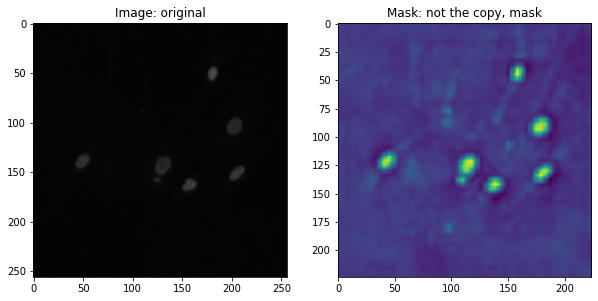

In [28]:
num_img=0
image = utils.imread(TEST_IMAGES[num_img])
plt.figure(figsize=(10, 14))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title(f"Image: original")

mask=predictions[num_img][0]
plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.title(f"Mask: not the copy, mask")

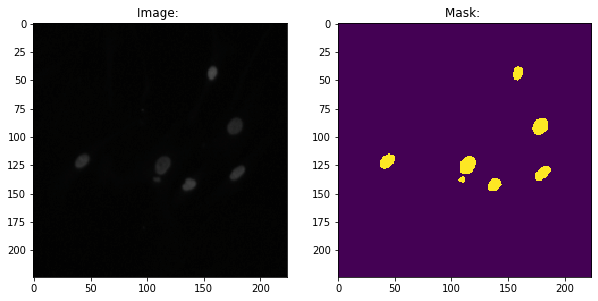

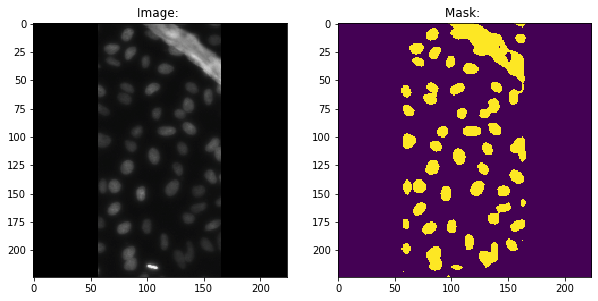

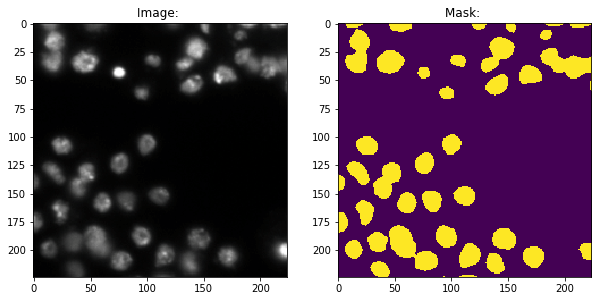

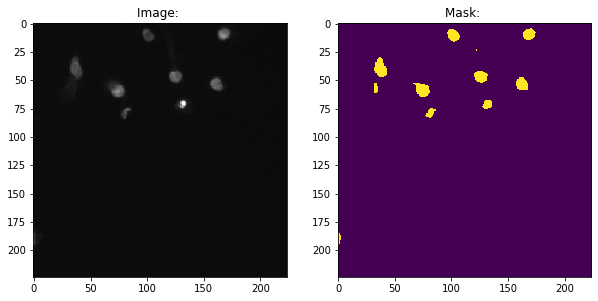

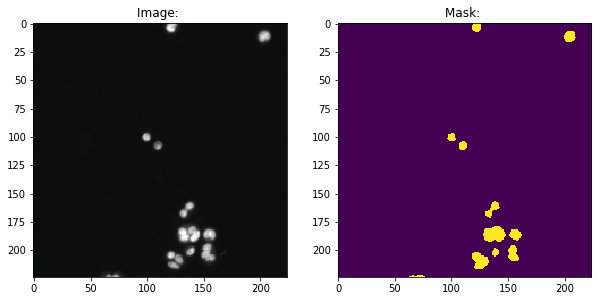

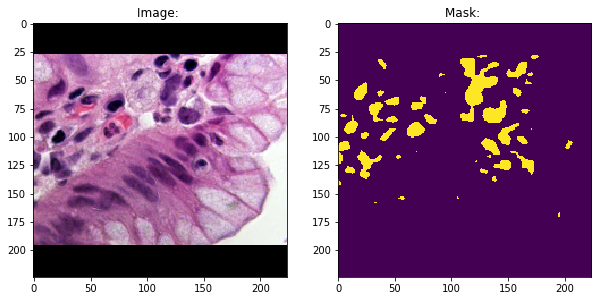

In [29]:

threshold = 0.5
max_count = 5

for i, (features, logits) in enumerate(zip(test_dataset, predictions)):
    image = utils.tensor_to_ndimage(features["image"])

    mask_ = torch.from_numpy(logits[0]).sigmoid()
    mask = utils.detach(mask_ > threshold).astype("float")
        
    show_examples(name="", image=image, mask=mask)
    
    if i >= max_count:
        break

# Задача - 7
## Описание модели

Ссылка на веса обученной модели - https://yadi.sk/d/lUaIImLENfQ-QQ

Ссылка на соревнование kaggle -https://www.kaggle.com/c/data-science-bowl-2018/data

Данная сеть может быть использована:
1. В задаче подсчета количества клеток для гистологических снимков. Данный подсчет может быть улучшен с введением дополнительной искуственной нейронной сети выделяющей границы клеток на изображении, которая позволит более точно выделить границы каждой клетки и производить подсчёт.
2. В задаче подсчета площади клеток для гистологических снимков. Могут быть выявлены клетки с отклонением от медианного (или среднего выборочного) размера, что может быть важно для гистологических исследований, например: при флуоресценции клеток другого (не основного для исследования) типа введенным маркером (будут иметься различия в размере).